In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataUtils.CustomDataset as CastomDataset

In [2]:
workers = 2
btch_sz = 8
num_epochs = 10
lr = 0.002
beta1 = 0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cpu


240 (1365, 2048, 3) [0 0 1 0]
241 (1365, 2048, 3) [0 0 1 0]
242 (1365, 2048, 3) [0 0 0 1]
243 (1365, 2048, 3) [0 0 0 1]
244 (1365, 2048, 3) [0 0 1 0]
245 (2048, 1365, 3) [0 1 0 0]
246 (1365, 2048, 3) [1 0 0 0]
247 (1365, 2048, 3) [1 0 0 0]
248 (1365, 2048, 3) [1 0 0 0]
249 (1365, 2048, 3) [1 0 0 0]
250 (1365, 2048, 3) [0 0 0 1]
251 (1365, 2048, 3) [0 0 0 1]


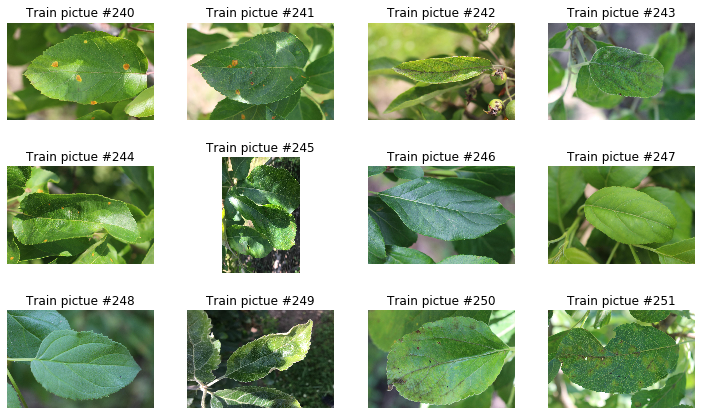

In [28]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv', 'images')

plt.figure(figsize=(10,10))
for i in range(240,252):
    sample = plant_dataset[i]
    print(i, sample['image'].shape, sample['labels'])
    
    ax = plt.subplot(5, 4, i-239)
    plt.tight_layout()
    ax.set_title('Train pictue #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
   

In [29]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv',
                                                    'images',
                                                    transform=CastomDataset.ToTensor()
                                                   )

dataloader = DataLoader(plant_dataset, batch_size=btch_sz,
                        shuffle=False, num_workers=workers)

In [30]:
batch = next(iter(dataloader))
batch['image'].shape, batch['labels'].shape

(torch.Size([8, 3, 1365, 2048]), torch.Size([8, 4]))

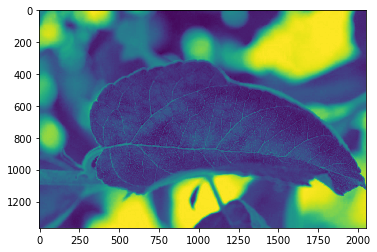

tensor([1, 0, 0, 0])


In [31]:
plt.imshow(batch['image'][2][0])
plt.show()
print(batch['labels'][2])

In [26]:
for i, batch in enumerate(dataloader):
    print('[{}/{}] {}'.format(i*btch_sz, btch_sz*len(dataloader), batch['image'].shape))

[0/1824] torch.Size([8, 3, 1365, 2048])
[8/1824] torch.Size([8, 3, 1365, 2048])
[16/1824] torch.Size([8, 3, 1365, 2048])
[24/1824] torch.Size([8, 3, 1365, 2048])
[32/1824] torch.Size([8, 3, 1365, 2048])
[40/1824] torch.Size([8, 3, 1365, 2048])
[48/1824] torch.Size([8, 3, 1365, 2048])
[56/1824] torch.Size([8, 3, 1365, 2048])
[64/1824] torch.Size([8, 3, 1365, 2048])
[72/1824] torch.Size([8, 3, 1365, 2048])
[80/1824] torch.Size([8, 3, 1365, 2048])
[88/1824] torch.Size([8, 3, 1365, 2048])
[96/1824] torch.Size([8, 3, 1365, 2048])
[104/1824] torch.Size([8, 3, 1365, 2048])
[112/1824] torch.Size([8, 3, 1365, 2048])
[120/1824] torch.Size([8, 3, 1365, 2048])
[128/1824] torch.Size([8, 3, 1365, 2048])
[136/1824] torch.Size([8, 3, 1365, 2048])
[144/1824] torch.Size([8, 3, 1365, 2048])
[152/1824] torch.Size([8, 3, 1365, 2048])
[160/1824] torch.Size([8, 3, 1365, 2048])
[168/1824] torch.Size([8, 3, 1365, 2048])
[176/1824] torch.Size([8, 3, 1365, 2048])
[184/1824] torch.Size([8, 3, 1365, 2048])
[192/18

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/anatolii/Tools/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/anatolii/Tools/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/anatolii/Tools/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/anatolii/Tools/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/anatolii/Tools/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1365 and 2048 in dimension 2 at /tmp/pip-req-build-ufslq_a9/aten/src/TH/generic/THTensor.cpp:612
